In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import keras
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras import activations
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconvolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Activation 
from keras.preprocessing.image import ImageDataGenerator
#Import for obtaining class activation heatmaps
from vis.losses import ActivationMaximization
from vis.regularizers import TotalVariation, LPNorm
from vis.optimizer import Optimizer
from vis.callbacks import GifGenerator
from vis.visualization import visualize_cam

#Linear Algebra and sklearn stuff
import numpy as np
import pandas
import matplotlib.pyplot as plt
import numpy
from PIL import Image

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, ball
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [30]:
ActivationMaximization??

In [2]:
train_patches_f = open('/home/sebastian/experiments/ScaleExperiments/dataset/patches_miccai18/training_patches_fnames.txt','r')
train_patches_fnames = []
train_masks_fnames = []

for line in train_patches_f:
    path_mask = '/'.join(line.split('/')[0:-1])
    mask_name = line.split('/')[-1]
    
    if "mask" not in mask_name: #Then is a patch
        a=0
        #train_patches_fnames.append(line.split()[0])
    else:
        mask_fn   = '_'.join(mask_name.split('_')[0:3]) + '_mask.png_'+ '_'.join(mask_name.split('_')[4:6])
        patch_fn =  '_'.join(mask_name.split('_')[0:3]) + '_original.tif_'+ '_'.join(mask_name.split('_')[4:6])

        train_masks_fnames.append(path_mask + '/' + mask_fn.split()[0])
        train_patches_fnames.append(path_mask + '/' + patch_fn.split()[0])


X_train = []
for im in train_patches_fnames:
    data = np.asarray(Image.open(im))[:,:,0:3]
    X_train.append(data)
X_train = np.array(X_train)


Y_train_avgareas = []
for im in train_masks_fnames:
    orig_img = np.asarray(Image.open(im))[:,:,0]
    thresh = threshold_otsu(orig_img)
    bw = closing(orig_img > thresh, square(2))
    cleared = clear_border(bw)
    label_img = label(cleared)
    props = regionprops(label_img)
    all_props_areas = []
    for region in props:
        # take regions with large enough areas
        if region.area >= 3:
            all_props_areas.append(region.area)
    Y_train_avgareas.append(np.average(all_props_areas))

Y_train_avgareas = np.array(Y_train_avgareas)


In [16]:
val_patches_f = open('/home/sebastian/experiments/ScaleExperiments/dataset/patches_miccai18/validation_patches_fnames.txt','r')
val_patches_fnames = []
val_masks_fnames = []

for line in val_patches_f:
    path_mask = '/'.join(line.split('/')[0:-1])
    mask_name = line.split('/')[-1]
    
    if "mask" not in mask_name: #Then is a patch
        a=0
        #train_patches_fnames.append(line.split()[0])
    else:
        mask_fn   = '_'.join(mask_name.split('_')[0:3]) + '_mask.png_'+ '_'.join(mask_name.split('_')[4:6])
        patch_fn =  '_'.join(mask_name.split('_')[0:3]) + '_original.tif_'+ '_'.join(mask_name.split('_')[4:6])

        val_masks_fnames.append(path_mask + '/' + mask_fn.split()[0])
        val_patches_fnames.append(path_mask + '/' + patch_fn.split()[0])


X_val = []
for im in val_patches_fnames:
    data = np.asarray(Image.open(im))[:,:,0:3]
    X_val.append(data)
X_val = np.array(X_val)




Y_val_avgareas = []
for im in val_masks_fnames:
    orig_img = np.asarray(Image.open(im))[:,:,0]
    thresh = threshold_otsu(orig_img)
    bw = closing(orig_img > thresh, square(2))
    cleared = clear_border(bw)
    label_img = label(cleared)
    props = regionprops(label_img)
    all_props_areas = []
    for region in props:
        # take regions with large enough areas
        if region.area >= 3:
            all_props_areas.append(region.area)
    Y_val_avgareas.append(np.average(all_props_areas))

Y_val_avgareas = np.array(Y_val_avgareas)


In [5]:
test_patches_f = open('/home/sebastian/experiments/ScaleExperiments/dataset/patches_miccai18/test_patches_fnames.txt','r')
test_patches_fnames = []
test_masks_fnames = []

for line in test_patches_f:
    path_mask = '/'.join(line.split('/')[0:-1])
    mask_name = line.split('/')[-1]
    
    if "mask" not in mask_name: #Then is a patch
        a=0
        #train_patches_fnames.append(line.split()[0])
    else:
        mask_fn   = '_'.join(mask_name.split('_')[0:3]) + '_mask.png_'+ '_'.join(mask_name.split('_')[4:6])
        patch_fn =  '_'.join(mask_name.split('_')[0:3]) + '_original.tif_'+ '_'.join(mask_name.split('_')[4:6])

        test_masks_fnames.append(path_mask + '/' + mask_fn.split()[0])
        test_patches_fnames.append(path_mask + '/' + patch_fn.split()[0])


X_test = []
for im in test_patches_fnames:
    data = np.asarray(Image.open(im))[:,:,0:3]
    X_test.append(data)
X_test = np.array(X_test)

Y_test_avgareas = []
for im in test_masks_fnames:
    orig_img = np.asarray(Image.open(im))[:,:,0]
    thresh = threshold_otsu(orig_img)
    bw = closing(orig_img > thresh, square(2))
    cleared = clear_border(bw)
    label_img = label(cleared)
    props = regionprops(label_img)
    all_props_areas = []
    for region in props:
        # take regions with large enough areas
        if region.area >= 3:
            all_props_areas.append(region.area)
    Y_test_avgareas.append(np.average(all_props_areas))

Y_test_avgareas = np.array(Y_test_avgareas)


In [7]:
print X_train.shape, Y_train_avgareas.shape
print X_val.shape, Y_val_avgareas.shape
print X_test.shape, Y_test_avgareas.shape

(22494, 224, 224, 3) (22494,)
(6353, 224, 224, 3) (6353,)
(5594, 224, 224, 3) (5594,)


In [17]:
# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=90.,
                     horizontal_flip=True,
                     vertical_flip=True,
                     
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
#mask_datagen.fit(masks, augment=True, seed=seed)

#image_generator = image_datagen.flow_from_directory(
#    'data/images',
#    class_mode=None,
#    seed=seed)

#mask_generator = mask_datagen.flow_from_directory(
#    'data/masks',
#    class_mode=None,
#    seed=seed)

# combine generators into one which yields image and masks
#train_generator = zip(image_generator, mask_generator)

#model.fit_generator(
#    train_generator,
#    steps_per_epoch=2000,
#    epochs=50)


In [8]:
magn_5x, magn_8x, magn_10x, magn_15x, magn_20x, magn_30x, magn_40x= [],[],[],[],[],[],[]
for i in range(len(test_masks_fnames)):
    magn = test_masks_fnames[i].split('/')[9]
    if magn == '5x':
        magn_5x.append(i)
    if magn == '8X':
        magn_8x.append(i)
    if magn == '10X':
        magn_10x.append(i)
    if magn == '15X':
        magn_15x.append(i)
    if magn == '20X':
        magn_20x.append(i)
    if magn == '30X':
        magn_30x.append(i)
    if magn == '40X':
        magn_40x.append(i)

In [25]:
all_idx_magn = magn_5x+ magn_8x+ magn_10x+ magn_15x+ magn_20x+ magn_30x+ magn_40x
len(all_idx_magn)

0

In [10]:
print Y_train_avgareas.shape
print Y_train_avgareas.sum(), Y_train_avgareas.min(), Y_train_avgareas.max(), Y_train_avgareas.std()
print "====================================================="
print Y_val_avgareas.shape
print Y_val_avgareas.sum(), Y_val_avgareas.min(), Y_val_avgareas.max(), Y_val_avgareas.std()
print "====================================================="
print Y_test_avgareas.shape
print Y_test_avgareas.sum(), Y_test_avgareas.min(), Y_test_avgareas.max(), Y_test_avgareas.std()


(22494,)
9667007.74522 12.3777777778 3391.0 375.247224929
(6353,)
3056492.42472 12.8461538462 3035.0 420.572547557
(5594,)
2453780.87253 17.6428571429 2402.0 358.007047012


In [11]:
# define base model
def baseline_model(lr,clip_norm):
    model_scale = Sequential() #Is sequential because all the 
    #Block 0
    model_scale.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),
                            padding='valid',
                            input_shape=input_shape))
    model_scale.add(Activation('relu'))
    #Block 1
    model_scale.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_scale.add(BatchNormalization())
    model_scale.add(Activation('relu'))
    model_scale.add(MaxPooling2D(pool_size=pool_size))
    model_scale.add(Dropout(0.25))
    #Block 2
    model_scale.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_scale.add(BatchNormalization())
    model_scale.add(Activation('relu'))
    model_scale.add(MaxPooling2D(pool_size=pool_size))
    model_scale.add(Dropout(0.25))
    #Block 3
    model_scale.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_scale.add(BatchNormalization())
    model_scale.add(Activation('relu'))
    model_scale.add(MaxPooling2D(pool_size=pool_size))
    model_scale.add(Dropout(0.25))
    model_scale.add(Flatten())
    #Block 4
    model_scale.add(Dense(128))#, activation= 'relu')
    model_scale.add(BatchNormalization())
    model_scale.add(Activation('relu'))
    model_scale.add(Dropout(0.25))
    model_scale.add(Dense(1))
    #Defining the optimizer
    sgd_opt = SGD(lr=lr, momentum=0.05, decay=0.0, nesterov=True)

    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1)
    else:
        adam_opt = Adam(lr)

    model_scale.compile(loss='mean_squared_error',
              optimizer=adam_opt ,
              metrics=['mae'])
    return model_scale

In [12]:
#If we want to resume the state of a previouly trained model
load_weights = False
if load_weights:
    path_pretrained = '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/models/miccai18/modelShallowNetRegressor_bestofthebest_weights.h5'
    model_scale.load_weights(path_pretrained)

In [26]:
# Setting the parameters and building the baseline model
lrs = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
nb_filters = 32
nb_epoch = 40
pool_size = (2, 2)
kernel_size = (3, 3)
input_shape = (224,224,3)

for lr in [0.001,0.01]:
    clip_norm = True 
    model_scale = baseline_model(lr,clip_norm)


    #Defining the CallBacks for tensorboard visualization and for earlystopping of the model
    path_checkpointer_model = '/home/sebastian/experiments/ScaleExperiments/models/miccai18/best_shallownet_weights_' 
    path_checkpointer_model += 'RGBo_DA_best40ep_' + str(lr)  + '.hdf5'
    path_tensorboard_log    = '/home/sebastian/experiments/ScaleExperiments/models/miccai18/logsTensorBoard/'
    path_tensorboard_log    += 'RGBo_DA_best40ep_' + str(lr) 

    checkpointer = ModelCheckpoint(filepath=path_checkpointer_model, monitor='val_mean_absolute_error', verbose=1, save_best_only=True)
    tb_callback = TensorBoard(log_dir=path_tensorboard_log, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    #model_scale.fit(X_train,Y_train_avgareas,nb_epoch=nb_epoch, validation_data=(X_val,Y_val_avgareas), batch_size=32,  verbose=1,callbacks=[checkpointer,tb_callback])
    
    model_scale.fit_generator(image_datagen.flow(X_train, Y_train_avgareas, batch_size=32), validation_data=(X_val,Y_val_avgareas),
                         callbacks=[checkpointer,tb_callback], verbose=1,steps_per_epoch=len(X_train) / 32, epochs=nb_epoch)


Epoch 1/40
702/702 [==============================] - 251s 357ms/step - loss: 277092.2733 - mean_absolute_error: 397.5422 - val_loss: 197577.8812 - val_mean_absolute_error: 292.5766
Epoch 2/40
702/702 [==============================] - 236s 336ms/step - loss: 132340.4235 - mean_absolute_error: 268.7583 - val_loss: 90849.4013 - val_mean_absolute_error: 217.7953
Epoch 3/40
702/702 [==============================] - 235s 335ms/step - loss: 51737.8138 - mean_absolute_error: 160.1169 - val_loss: 149051.9092 - val_mean_absolute_error: 345.4071
Epoch 4/40
702/702 [==============================] - 235s 335ms/step - loss: 33888.3908 - mean_absolute_error: 121.5233 - val_loss: 480666.7764 - val_mean_absolute_error: 660.2260
Epoch 5/40
702/702 [==============================] - 235s 335ms/step - loss: 30277.8402 - mean_absolute_error: 112.9205 - val_loss: 128189.0863 - val_mean_absolute_error: 304.2491
Epoch 6/40
702/702 [==============================] - 235s 335ms/step - loss: 27512.5874 - mea

Epoch 5/40
702/702 [==============================] - 234s 334ms/step - loss: 29913.3788 - mean_absolute_error: 110.3439 - val_loss: 63052.1429 - val_mean_absolute_error: 153.8473
Epoch 6/40
702/702 [==============================] - 235s 334ms/step - loss: 27991.5416 - mean_absolute_error: 106.7556 - val_loss: 62364.6074 - val_mean_absolute_error: 190.7123
Epoch 7/40
702/702 [==============================] - 235s 334ms/step - loss: 27239.9785 - mean_absolute_error: 105.1341 - val_loss: 50772.9743 - val_mean_absolute_error: 181.6003
Epoch 8/40
702/702 [==============================] - 234s 334ms/step - loss: 26905.1276 - mean_absolute_error: 104.2124 - val_loss: 63189.8833 - val_mean_absolute_error: 189.9079
Epoch 9/40
702/702 [==============================] - 235s 334ms/step - loss: 26266.2780 - mean_absolute_error: 102.4866 - val_loss: 117490.5800 - val_mean_absolute_error: 304.7140
Epoch 10/40
702/702 [==============================] - 234s 334ms/step - loss: 26135.2587 - mean_ab

In [67]:
Y_hat = model_scale.predict(X_test)

idx_test = range(2000,2100)
print Y_test_avgareas[idx_test]
print "\n"
print Y_hat[idx_test].T.squeeze() 
print "\n"

[ 1011.33333333  1349.          1217.5         1053.33333333   873.5
  1053.33333333  1353.5         1174.          1217.5         1289.5          812.
  1353.5         1341.          1186.           969.          1011.33333333
  1128.5         1371.66666667  1286.33333333    21.01886792    20.76923077
    45.95          49.15          43.7           45.3030303     45.5
    44.4516129     40.34482759    45.87878788    46.24137931    45.76666667
    45.5           42.83333333    46.60714286    46.            40.07407407
    68.88888889    65.21428571    65.21428571    75.42857143    68.08333333
    71.45454545    71.45454545    71.33333333    71.55555556    74.5
    67.57142857    66.            72.57142857    74.94444444    72.5
    75.75          76.33333333    75.71428571   180.57142857   177.           162.5
   170.8          170.5          161.85714286   160.6          178.25
   160.           186.5          156.5          162.           180.57142857
   190.5          157.42857143 

In [22]:
print model_scale.evaluate(X_test,Y_test_avgareas)

5594/5594 [==============================] - 87s 15ms/step
[402056.46388988203, 586.25396752519441]


In [47]:
#If we want to save the trained model
from keras.utils import plot_model
save_last_model = True
if save_last_model:
    path_model = '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/models/miccai18/modelShallowNetRegressor_RGB_lr0001_271valMAE.h5'
    plot_model(model_scale, to_file='/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/models/miccai18/modelShallowNetRegressor.png')
    model_scale.save_weights(path_model)

In [70]:
y_hat_smoothed = smooth(Y_hat.squeeze())
y_smoothed = smooth(Y_test_avgareas.squeeze())

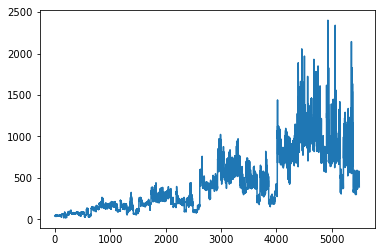

In [69]:
plt.plot(x_range,Y_test_avgareas[all_idx_magn][x_range])
plt.show()

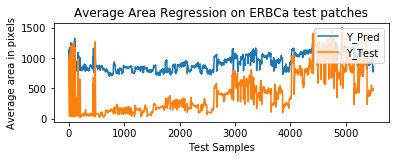

In [85]:
from pylab import *
windows=['y_hat_smoothed', 'y_smoothed']

num_test_smpls = 5500
x_range = range(num_test_smpls)
plt.plot(x_range,Y_test_avgareas[all_idx_magn][x_range].squeeze().tolist())

legend(windows)
subplot(212)
plot(x_range, y_hat_smoothed[all_idx_magn][x_range].squeeze().tolist())
plot(x_range, y_smoothed[all_idx_magn][x_range].squeeze().tolist())
#l=['Y_Pred', 'Y_Test']
plt.ylabel('Average area in pixels')
plt.xlabel('Test Samples')
plt.legend(['Y_Pred', 'Y_Test'], loc='upper right')

title("Average Area Regression on ERBCa test patches")
#l.extend(windows)
plt.savefig('/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/results/regression_test_psm.eps')
#legend(l)
show()

In [77]:
print X_test.shape
print Y_test_avgareas.shape

(5594, 224, 224, 3)
(5594,)


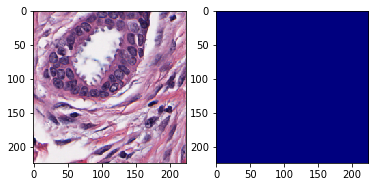

Predicted avg area:[[ 793.04302979]]- Ground Truth: 163.9375


In [84]:
smpl_idx = 5442
layer_name = 'predictions'
layer_idx = -2

im_test_orig = X_test[smpl_idx]#np.asarray(Image.open(path_pmc_test))[:,:,0:3]
im_test = im_test_orig[0:224,0:224,:]
plt.figure(1)
plt.subplot(121)
plt.imshow(im_test)
plt.subplot(122)

pp = visualize_cam(model_scale, layer_idx, filter_indices=None, seed_input=X_test[smpl_idx], penultimate_layer_idx=None,
              backprop_modifier=None, grad_modifier=None)
plt.imshow(pp)
plt.show()
print "Predicted avg area:" + str( model_scale.predict(np.expand_dims(X_test[smpl_idx],axis=0))) + "- Ground Truth: " + str(Y_test_avgareas[smpl_idx])

In [55]:
pp.sum()

6372352

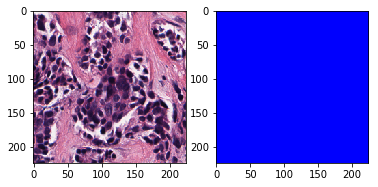

Predicted avg area:[[ 779.68762207]]- Ground Truth: 118.0


In [78]:
smpl_idx = 5029
layer_name = 'predictions'
layer_idx = -3

im_test_orig = X_test[smpl_idx]
im_test = im_test_orig[0:224,0:224,:]
plt.figure(1)
plt.subplot(121)
plt.imshow(im_test_orig)
plt.subplot(122)

pp = visualize_cam(model_scale, layer_idx, filter_indices=None, seed_input=X_test[smpl_idx], penultimate_layer_idx=None,
              backprop_modifier=None, grad_modifier=None)
plt.imshow(pp*2)
plt.show()
print "Predicted avg area:" + str( model_scale.predict(np.expand_dims(X_test[smpl_idx],axis=0))) + "- Ground Truth: " + str(Y_test_avgareas[smpl_idx])



In [89]:
from os import listdir
from os.path import isfile, join

def test_on_pubmed_subset(model,path_pubmed):
    all_imgs_paths = [f for f in listdir(path_pubmed) if isfile(join(path_pubmed, f))]
    fiveX_magn_files, tenX_magn_files, twentyX_magn_files = [],[],[]
    for item in all_imgs_paths:
        if item.split('_')[0] == '5X':
            fiveX_magn_files.append(path_pubmed+item)
        if item.split('_')[0] == '10X':
            tenX_magn_files.append(path_pubmed+item)
        if item.split('_')[0] == '20X':
            twentyX_magn_files.append(path_pubmed+item)
    fiveX_labels = np.zeros(len(fiveX_magn_files))
    tenX_labels = np.zeros(len(tenX_magn_files)) + 1 
    twentyX_labels = np.zeros(len(twentyX_magn_files)) + 2
    return fiveX_magn_files,tenX_magn_files,twentyX_magn_files

path_pubmed = '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/'
fiveX_magn_files,tenX_magn_files,twentyX_magn_files = test_on_pubmed_subset(model_scale,path_pubmed)
    

In [101]:
twentyX_magn_files

['/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC4695200_1b.png',
 '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3717517.png',
 '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3717524_b.png',
 '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC4216672_224.jpg',
 '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3252392_g.png',
 '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3252392_h.png',
 '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC4216672.jpg',
 '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3717517_d.png',
 '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC4695200_1

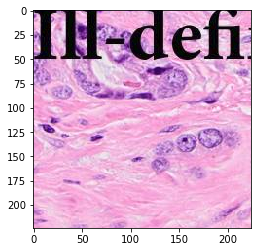

In [114]:
im_test_orig = np.asarray(Image.open(path_test))[:,:,0:3]
plt.imshow(im_test_orig[0:224,0:224,:])
plt.show()

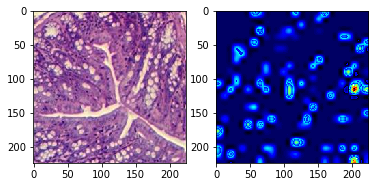

Predicted avg area:[[ 485.22042847]]


In [185]:
#path_pmc_test = '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/5X_PMC3775960_8b.png'
path_pmc_test = '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/5X_PMC3775960_b.png'
im_test_orig = np.asarray(Image.open(path_pmc_test))[:,:,0:3]
im_test = im_test_orig[0:224,0:224,:]
plt.figure(1)
plt.subplot(121)
plt.imshow(im_test)
plt.subplot(122)

pp = visualize_cam(model_scale, layer_idx, filter_indices=None, seed_input=im_test, penultimate_layer_idx=None,
              backprop_modifier=None, grad_modifier=None)
plt.imshow(pp*3)
plt.show()
print "Predicted avg area:" + str( model_scale.predict(np.expand_dims(im_test,axis=0)))


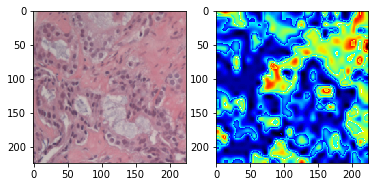

Predicted avg area:[[ 1222.8013916]]


In [192]:
#path_pmc_test = '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3717524_a.png'
#path_pmc_test = '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3717524_b.png'
path_pmc_test = '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3717524_a.png'
im_test_orig = np.asarray(Image.open(path_pmc_test))[:,:,0:3]
im_test = im_test_orig[0:224,0:224,:]
plt.figure(1)
plt.subplot(121)
plt.imshow(im_test)
plt.subplot(122)

pp = visualize_cam(model_scale, layer_idx, filter_indices=None, seed_input=im_test, penultimate_layer_idx=None,
              backprop_modifier=None, grad_modifier=None)
plt.imshow(pp*2)
plt.show()
print "Predicted avg area:" + str( model_scale.predict(np.expand_dims(im_test_orig[0:224,0:224,:],axis=0)))


In [ ]:
#path_pmc_test = '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3717524_a.png'
#path_pmc_test = '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3717524_b.png'
path_pmc_test = '/home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3717524_a.png'
im_test_orig = np.asarray(Image.open(path_pmc_test))[:,:,0:3]
im_test = im_test_orig[0:224,0:224,:]
plt.figure(1)
plt.subplot(121)
plt.imshow(im_test)
plt.subplot(122)

pp = visualize_cam(model_scale, layer_idx, filter_indices=None, seed_input=im_test, penultimate_layer_idx=None,
              backprop_modifier=None, grad_modifier=None)
plt.imshow(pp*2)
plt.show()
print "Predicted avg area:" + str( model_scale.predict(np.expand_dims(im_test_orig[0:224,0:224,:],axis=0)))


In [137]:
for path_test in twentyX_magn_files:
    #im_test = resize((np.asarray(Image.open(path_test)))[:,:,0:3], (224, 224,3))
    #im_test = im_test[,:,:]
    #plt.imshow(im_test)
    try:
        im_test_orig = np.asarray(Image.open(path_test))[:,:,0:3]
        im_test = im_test_orig[0:224,0:224,:]
        #plt.imshow(im_test_orig[0:224,0:224,:])

        print im_test.shape
        #print scale_factor
        #    data = imresize(np.asarray(Image.open(imaa))[:,:,0:3],scale_factor,'bicubic').astype('float32')
        #model2.predict(np.swapaxes(np.expand_dims(im_test,axis=0), 3,1))
        cur_pred = model_scale.predict(np.expand_dims(im_test,axis=0))
        print 'Prediction for ' + path_test + ' is: ' + str(np.argmax(cur_pred)) + ' with prob ' + str(cur_pred)
    except ValueError:
        print "Too small image " + path_test

(224, 224, 3)
Prediction for /home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC4695200_1b.png is: 0 with prob [[ 477.1305542]]
(224, 224, 3)
Prediction for /home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3717517.png is: 0 with prob [[ 697.15905762]]
(224, 224, 3)
Prediction for /home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3717524_b.png is: 0 with prob [[ 1162.36291504]]
(224, 224, 3)
Prediction for /home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC4216672_224.jpg is: 0 with prob [[ 343.90231323]]
(224, 224, 3)
Prediction for /home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3252392_g.png is: 0 with prob [[ 517.89666748]]
(224, 224, 3)
Prediction for /home/sebastian/local_experiments/karolinska_DL/ScaleExperiments/test_pubmed_imgs/imgs/20X_PMC3252392_h.png is: 0 w

In [ ]:
# Note: Must be very consistent in naming, checkpoint file has to be named the same thing as tensor (I think)
pred_probs = tf.Variable(pred_res, name='pred_probs')
    
metadata_path = os.path.join(log_dir, 'metadata.tsv')
metadata_cols = ['title', 'class']
with open(metadata_path, 'w') as met_fi:
    met_fi.write('%s\n' % '\t'.join(metadata_cols))
    for rn in range(act_res.shape[0]):
        cur_col = [all_titles[rn], '%d' % act_res[rn]]
        met_fi.write('%s\n' % '\t'.join(cur_col))
            
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = pred_probs.name
embedding.metadata_path = metadata_path
    
# Use the same LOG_DIR where you stored your checkpoint.
init_op = tf.variables_initializer([pred_probs])
with tf.Session() as sess:
    sess.run(init_op)
    saver = tf.train.Saver({'pred_probs': pred_probs})
    saver.save(sess, os.path.join(log_dir, "pred_probs.ckpt"))

    summary_writer = tf.summary.FileWriter(log_dir)
    
    # The next line writes a projector_config.pbtxt in the LOG_DIR. TensorBoard will
    # read this file during startup.
    projector.visualize_embeddings(summary_writer, config)

In [84]:
model_scale.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
activation_21 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
batch_normalization_17 (Batc (None, 220, 220, 32)      128       
_________________________________________________________________
activation_22 (Activation)   (None, 220, 220, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 110, 110, 32)      0         
__________

In [ ]:
from keras.models import Model
layer_name = 'activation_15'
intermediate_layer_model = Model(inputs=model_scale.input,
                                 outputs=model_scale.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_test)


In [ ]:
intermediate_output[subsamples_array].isnan()

In [ ]:
num_subsamples_embeddings = 5000
subsamples_array = range(num_subsamples_embeddings)
np.random.shuffle(subsamples_array)


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=28, n_components=2, init='pca', n_iter=1000)
low_dim_embeds = tsne.fit_transform(np.array(intermediate_output[subsamples_array]))

In [19]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y


